<a href="https://colab.research.google.com/github/adalbertii/Modele-klasyfikacyjne/blob/main/CNN_news_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
# aby upewnić się, że zestaw danych został dodany poprawnie

!ls '/content/drive/MyDrive/dane/20_newsgroup/'

 alt.atheism		    misc.forsale	 sci.space
 comp.graphics		    rec.autos		 soc.religion.christian
 comp.os.ms-windows.misc    rec.motorcycles	 talk.politics.guns
 comp.sys.ibm.pc.hardware   rec.sport.baseball	 talk.politics.mideast
 comp.sys.mac.hardware	    rec.sport.hockey	 talk.politics.misc
 comp.windows.x		    sci.crypt		 talk.religion.misc
 glove.6B.100d.txt	    sci.electronics
'Kopia glove.6B.100d.txt'   sci.med


In [4]:
# ścieżka zbioru danych
TEXT_DATA_DIR = r'/content/drive/MyDrive/dane/20_newsgroup/'

#ścieżka dla osadzeń Glove
GLOVE_DIR = r'/content/drive/MyDrive/dane/glove/'

# maksymalna długość słowa powinna być stała
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000

#
VALIDATION_SPLIT = 0.20

# wymiar wektorów, które mają zostać użyte
EMBEDDING_DIM = 100

# rozmiary filtrów różnych warstw konwolucji
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100


drop = 0.5
batch_size = 30
epochs = 2



TRUKTURA ZBIORU DANYCH

Zbiór danych ma strukturę hierarchiczną, tj. wszystkie pliki danej klasy znajdują się w odpowiednich folderach, a każdy punkt danych ma swój własny plik ".txt".

    Najpierw przechodzimy przez cały zbiór danych, aby zbudować naszą listę tekstową i listę etykiet.
    Następnie tokenizujemy całe dane za pomocą Tokenizer, który jest częścią keras.preprocessing.text.
    Następnie dodajemy dopełnienie do sekwencji, aby nadać im jednolitą długość.



In [5]:
## przygotowanie zbioru danych


texts = []  # lista próbek tekstu
labels_index = {}  # słownik mapujący nazwę etykiety na numeryczny identyfikator
labels = []  # lista ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # pomiń nagłówek
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)
print(labels_index)

print('Found %s texts.' % len(texts))

{'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
Found 19997 texts.


In [6]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 174074
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
# spodział danych na zestaw treningowy i zestaw walidacyjny
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Ponieważ mamy już gotowy podział na trening i walidację, następnym krokiem jest utworzenie macierzy osadzania na podstawie wstępnie obliczonych osadzeń Glove. Dla wygody zamrażamy warstwę osadzania, tj. nie będziemy dostrajać osadzania słów. Zachęcamy do przetestowania go w celu uzyskania lepszej dokładności na bardzo konkretnych przykładach. Z tego, co widać, osadzenia Glove są uniwersalnymi funkcjami i ogólnie mają tendencję do osiągania świetnych wyników.

In [8]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        # słowa, których nie znaleziono w indeksie osadzania, będą miały wszystkie zera
        embedding_matrix[i] = embedding_vector

In [10]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [17]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='softmax')(dropout)

# budowa modelu
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(None, 1000, 100)
(None, 1000, 100, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            1740750   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 reshape_4 (Reshape)         (None, 1000, 100, 1)         0         ['embedding[4][0]']           
                                                                                                  
 conv2d_12 (Conv2D)          (None, 998, 1, 512)     

In [19]:
print("Traning Model...")
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/20
533/534 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.0906

534/534 [==============================] - 17s 27ms/step - loss: 0.2457 - accuracy: 0.0906 - val_loss: 0.1729 - val_accuracy: 0.4306
Epoch 2/20
532/534 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.2485

534/534 [==============================] - 15s 27ms/step - loss: 0.1803 - accuracy: 0.2488 - val_loss: 0.1410 - val_accuracy: 0.5971
Epoch 3/20
532/534 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.4153

534/534 [==============================] - 14s 27ms/step - loss: 0.1468 - accuracy: 0.4153 - val_loss: 0.1221 - val_accuracy: 0.6537
Epoch 4/20
533/534 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.5271

534/534 [==============================] - 14s 27ms/step - loss: 0.1268 - accuracy: 0.5271 - val_loss: 0.1098 - val_accuracy: 0.6887
Epoch 5/20
533/534 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.6105

534/534 [==============================] - 15s 28ms/step - loss: 0.1125 - accuracy: 0.6106 - val_loss: 0.1002 - val_accuracy: 0.7262
Epoch 6/20
532/534 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.6653

534/534 [==============================] - 15s 27ms/step - loss: 0.1020 - accuracy: 0.6657 - val_loss: 0.0938 - val_accuracy: 0.7339
Epoch 7/20
532/534 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.6998

534/534 [==============================] - 16s 30ms/step - loss: 0.0941 - accuracy: 0.6998 - val_loss: 0.0887 - val_accuracy: 0.7512
Epoch 8/20
533/534 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.7306

534/534 [==============================] - 14s 27ms/step - loss: 0.0876 - accuracy: 0.7306 - val_loss: 0.0842 - val_accuracy: 0.7592
Epoch 9/20
533/534 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.7525

534/534 [==============================] - 15s 27ms/step - loss: 0.0821 - accuracy: 0.7525 - val_loss: 0.0810 - val_accuracy: 0.7657
Epoch 10/20
534/534 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.7732

534/534 [==============================] - 14s 27ms/step - loss: 0.0765 - accuracy: 0.7732 - val_loss: 0.0779 - val_accuracy: 0.7719
Epoch 11/20
534/534 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.7895

534/534 [==============================] - 14s 27ms/step - loss: 0.0727 - accuracy: 0.7895 - val_loss: 0.0766 - val_accuracy: 0.7707
Epoch 12/20
532/534 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.8034

534/534 [==============================] - 14s 27ms/step - loss: 0.0695 - accuracy: 0.8037 - val_loss: 0.0733 - val_accuracy: 0.7797
Epoch 13/20
532/534 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.8174

534/534 [==============================] - 14s 27ms/step - loss: 0.0651 - accuracy: 0.8173 - val_loss: 0.0716 - val_accuracy: 0.7829
Epoch 14/20
532/534 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.8241

534/534 [==============================] - 16s 30ms/step - loss: 0.0624 - accuracy: 0.8240 - val_loss: 0.0702 - val_accuracy: 0.7819
Epoch 15/20
532/534 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.8386

534/534 [==============================] - 14s 27ms/step - loss: 0.0597 - accuracy: 0.8385 - val_loss: 0.0686 - val_accuracy: 0.7869
Epoch 16/20
533/534 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.8528

534/534 [==============================] - 15s 29ms/step - loss: 0.0571 - accuracy: 0.8529 - val_loss: 0.0674 - val_accuracy: 0.7902
Epoch 17/20
532/534 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.8594

534/534 [==============================] - 14s 27ms/step - loss: 0.0544 - accuracy: 0.8594 - val_loss: 0.0666 - val_accuracy: 0.7917
Epoch 18/20
532/534 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.8664

534/534 [==============================] - 14s 27ms/step - loss: 0.0520 - accuracy: 0.8666 - val_loss: 0.0649 - val_accuracy: 0.7984
Epoch 19/20
533/534 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.8766

534/534 [==============================] - 19s 35ms/step - loss: 0.0497 - accuracy: 0.8767 - val_loss: 0.0644 - val_accuracy: 0.7982
Epoch 20/20
532/534 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.8846

534/534 [==============================] - 16s 30ms/step - loss: 0.0478 - accuracy: 0.8846 - val_loss: 0.0634 - val_accuracy: 0.8005


In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


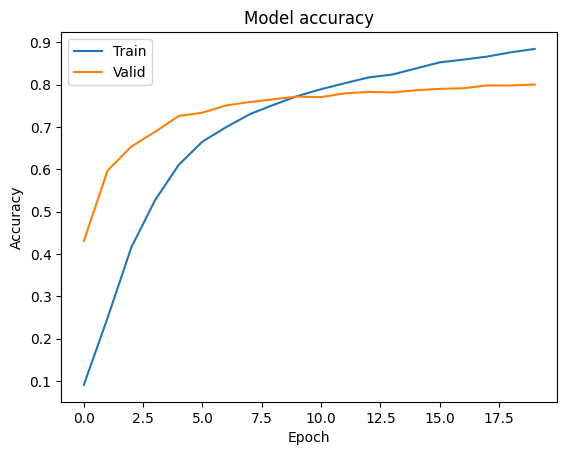

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

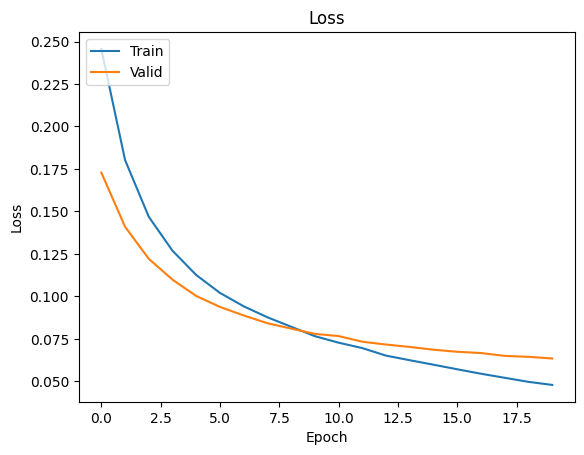

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [23]:
# ewaluacja modelu
eval = model.evaluate(x_val, y_val)

125/125 [==============================] - 1s 10ms/step - loss: 0.0634 - accuracy: 0.8005


In [24]:
print("Traning Model...")
epochs = 80
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/80
532/534 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.8872

534/534 [==============================] - 14s 27ms/step - loss: 0.0459 - accuracy: 0.8874 - val_loss: 0.0630 - val_accuracy: 0.8007
Epoch 2/80
533/534 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.8946

534/534 [==============================] - 14s 27ms/step - loss: 0.0443 - accuracy: 0.8945 - val_loss: 0.0627 - val_accuracy: 0.8022
Epoch 3/80
532/534 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.8965

534/534 [==============================] - 14s 27ms/step - loss: 0.0428 - accuracy: 0.8964 - val_loss: 0.0615 - val_accuracy: 0.8052
Epoch 4/80
533/534 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9054

534/534 [==============================] - 14s 27ms/step - loss: 0.0412 - accuracy: 0.9055 - val_loss: 0.0613 - val_accuracy: 0.8072
Epoch 5/80
533/534 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9104

534/534 [==============================] - 14s 26ms/step - loss: 0.0397 - accuracy: 0.9104 - val_loss: 0.0608 - val_accuracy: 0.8077
Epoch 6/80
534/534 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9186

534/534 [==============================] - 15s 28ms/step - loss: 0.0380 - accuracy: 0.9186 - val_loss: 0.0601 - val_accuracy: 0.8080
Epoch 7/80
533/534 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9210

534/534 [==============================] - 14s 27ms/step - loss: 0.0369 - accuracy: 0.9211 - val_loss: 0.0601 - val_accuracy: 0.8097
Epoch 8/80
534/534 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9248

534/534 [==============================] - 14s 27ms/step - loss: 0.0358 - accuracy: 0.9248 - val_loss: 0.0601 - val_accuracy: 0.8067
Epoch 9/80
532/534 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9288

534/534 [==============================] - 14s 27ms/step - loss: 0.0344 - accuracy: 0.9289 - val_loss: 0.0591 - val_accuracy: 0.8062
Epoch 10/80
533/534 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9303

534/534 [==============================] - 14s 26ms/step - loss: 0.0337 - accuracy: 0.9304 - val_loss: 0.0597 - val_accuracy: 0.8102
Epoch 11/80
533/534 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9300

534/534 [==============================] - 14s 27ms/step - loss: 0.0328 - accuracy: 0.9299 - val_loss: 0.0587 - val_accuracy: 0.8105
Epoch 12/80
533/534 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9366

534/534 [==============================] - 14s 27ms/step - loss: 0.0314 - accuracy: 0.9366 - val_loss: 0.0592 - val_accuracy: 0.8120
Epoch 13/80
533/534 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9398

534/534 [==============================] - 14s 27ms/step - loss: 0.0303 - accuracy: 0.9399 - val_loss: 0.0599 - val_accuracy: 0.8122
Epoch 14/80
532/534 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9392

534/534 [==============================] - 14s 26ms/step - loss: 0.0294 - accuracy: 0.9391 - val_loss: 0.0592 - val_accuracy: 0.8082
Epoch 15/80
533/534 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9435

534/534 [==============================] - 14s 27ms/step - loss: 0.0286 - accuracy: 0.9436 - val_loss: 0.0583 - val_accuracy: 0.8125
Epoch 16/80
533/534 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9455

534/534 [==============================] - 14s 26ms/step - loss: 0.0279 - accuracy: 0.9454 - val_loss: 0.0587 - val_accuracy: 0.8130
Epoch 17/80
534/534 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9466

534/534 [==============================] - 14s 27ms/step - loss: 0.0271 - accuracy: 0.9466 - val_loss: 0.0592 - val_accuracy: 0.8125
Epoch 18/80
534/534 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9481

534/534 [==============================] - 14s 27ms/step - loss: 0.0264 - accuracy: 0.9481 - val_loss: 0.0584 - val_accuracy: 0.8135
Epoch 19/80
533/534 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9487

534/534 [==============================] - 14s 27ms/step - loss: 0.0256 - accuracy: 0.9487 - val_loss: 0.0584 - val_accuracy: 0.8140
Epoch 20/80
532/534 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9509

534/534 [==============================] - 14s 27ms/step - loss: 0.0250 - accuracy: 0.9509 - val_loss: 0.0590 - val_accuracy: 0.8152
Epoch 21/80
534/534 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9539

534/534 [==============================] - 14s 27ms/step - loss: 0.0247 - accuracy: 0.9539 - val_loss: 0.0588 - val_accuracy: 0.8142
Epoch 22/80
532/534 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9557

534/534 [==============================] - 14s 27ms/step - loss: 0.0238 - accuracy: 0.9557 - val_loss: 0.0603 - val_accuracy: 0.8162
Epoch 23/80
533/534 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9547

534/534 [==============================] - 14s 27ms/step - loss: 0.0234 - accuracy: 0.9547 - val_loss: 0.0588 - val_accuracy: 0.8135
Epoch 24/80
532/534 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9572

534/534 [==============================] - 14s 26ms/step - loss: 0.0227 - accuracy: 0.9571 - val_loss: 0.0589 - val_accuracy: 0.8162
Epoch 25/80
532/534 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9555

534/534 [==============================] - 14s 27ms/step - loss: 0.0226 - accuracy: 0.9556 - val_loss: 0.0594 - val_accuracy: 0.8142
Epoch 26/80
532/534 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9590

534/534 [==============================] - 14s 27ms/step - loss: 0.0215 - accuracy: 0.9591 - val_loss: 0.0598 - val_accuracy: 0.8130
Epoch 27/80
532/534 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9596

534/534 [==============================] - 14s 27ms/step - loss: 0.0214 - accuracy: 0.9596 - val_loss: 0.0595 - val_accuracy: 0.8142
Epoch 28/80
532/534 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9601

534/534 [==============================] - 14s 27ms/step - loss: 0.0209 - accuracy: 0.9602 - val_loss: 0.0597 - val_accuracy: 0.8142
Epoch 29/80
533/534 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9609

534/534 [==============================] - 14s 27ms/step - loss: 0.0204 - accuracy: 0.9609 - val_loss: 0.0601 - val_accuracy: 0.8145
Epoch 30/80
532/534 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9624

534/534 [==============================] - 14s 27ms/step - loss: 0.0199 - accuracy: 0.9625 - val_loss: 0.0591 - val_accuracy: 0.8145
Epoch 31/80
532/534 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9622

534/534 [==============================] - 14s 27ms/step - loss: 0.0197 - accuracy: 0.9622 - val_loss: 0.0602 - val_accuracy: 0.8115
Epoch 32/80
533/534 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9643

534/534 [==============================] - 14s 27ms/step - loss: 0.0187 - accuracy: 0.9643 - val_loss: 0.0614 - val_accuracy: 0.8162
Epoch 33/80
533/534 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9631

534/534 [==============================] - 14s 27ms/step - loss: 0.0188 - accuracy: 0.9630 - val_loss: 0.0599 - val_accuracy: 0.8132
Epoch 34/80
533/534 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9662

534/534 [==============================] - 14s 27ms/step - loss: 0.0183 - accuracy: 0.9662 - val_loss: 0.0606 - val_accuracy: 0.8135
Epoch 35/80
532/534 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9649

534/534 [==============================] - 14s 27ms/step - loss: 0.0182 - accuracy: 0.9649 - val_loss: 0.0600 - val_accuracy: 0.8135
Epoch 36/80
533/534 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9636

534/534 [==============================] - 15s 27ms/step - loss: 0.0180 - accuracy: 0.9636 - val_loss: 0.0603 - val_accuracy: 0.8140
Epoch 37/80
532/534 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9650

534/534 [==============================] - 14s 27ms/step - loss: 0.0178 - accuracy: 0.9649 - val_loss: 0.0604 - val_accuracy: 0.8145
Epoch 38/80
533/534 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9653

534/534 [==============================] - 15s 27ms/step - loss: 0.0174 - accuracy: 0.9653 - val_loss: 0.0621 - val_accuracy: 0.8157
Epoch 39/80
533/534 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9659

534/534 [==============================] - 14s 27ms/step - loss: 0.0171 - accuracy: 0.9657 - val_loss: 0.0611 - val_accuracy: 0.8142
Epoch 40/80
532/534 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9677

534/534 [==============================] - 15s 27ms/step - loss: 0.0165 - accuracy: 0.9677 - val_loss: 0.0621 - val_accuracy: 0.8160
Epoch 41/80
532/534 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9687

534/534 [==============================] - 14s 27ms/step - loss: 0.0163 - accuracy: 0.9687 - val_loss: 0.0610 - val_accuracy: 0.8182
Epoch 42/80
532/534 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9659

534/534 [==============================] - 14s 27ms/step - loss: 0.0167 - accuracy: 0.9660 - val_loss: 0.0615 - val_accuracy: 0.8155
Epoch 43/80
532/534 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9691

534/534 [==============================] - 14s 27ms/step - loss: 0.0159 - accuracy: 0.9692 - val_loss: 0.0625 - val_accuracy: 0.8137
Epoch 44/80
533/534 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9679

534/534 [==============================] - 14s 27ms/step - loss: 0.0159 - accuracy: 0.9679 - val_loss: 0.0629 - val_accuracy: 0.8147
Epoch 45/80
533/534 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9692

534/534 [==============================] - 14s 27ms/step - loss: 0.0157 - accuracy: 0.9692 - val_loss: 0.0627 - val_accuracy: 0.8157
Epoch 46/80
533/534 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9684

534/534 [==============================] - 14s 27ms/step - loss: 0.0154 - accuracy: 0.9682 - val_loss: 0.0627 - val_accuracy: 0.8145
Epoch 47/80
532/534 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9686

534/534 [==============================] - 14s 27ms/step - loss: 0.0154 - accuracy: 0.9686 - val_loss: 0.0625 - val_accuracy: 0.8175
Epoch 48/80
533/534 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9694

534/534 [==============================] - 14s 27ms/step - loss: 0.0149 - accuracy: 0.9694 - val_loss: 0.0633 - val_accuracy: 0.8150
Epoch 49/80
533/534 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9674

534/534 [==============================] - 14s 27ms/step - loss: 0.0151 - accuracy: 0.9674 - val_loss: 0.0648 - val_accuracy: 0.8162
Epoch 50/80
533/534 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9700

534/534 [==============================] - 14s 27ms/step - loss: 0.0146 - accuracy: 0.9700 - val_loss: 0.0635 - val_accuracy: 0.8142
Epoch 51/80
533/534 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9679

534/534 [==============================] - 14s 27ms/step - loss: 0.0148 - accuracy: 0.9679 - val_loss: 0.0638 - val_accuracy: 0.8167
Epoch 52/80
533/534 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9700

534/534 [==============================] - 14s 27ms/step - loss: 0.0144 - accuracy: 0.9700 - val_loss: 0.0641 - val_accuracy: 0.8160
Epoch 53/80
533/534 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9687

534/534 [==============================] - 14s 26ms/step - loss: 0.0144 - accuracy: 0.9687 - val_loss: 0.0656 - val_accuracy: 0.8160
Epoch 54/80
532/534 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9687

534/534 [==============================] - 14s 27ms/step - loss: 0.0142 - accuracy: 0.9688 - val_loss: 0.0649 - val_accuracy: 0.8170
Epoch 55/80
533/534 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9703

534/534 [==============================] - 14s 27ms/step - loss: 0.0137 - accuracy: 0.9703 - val_loss: 0.0656 - val_accuracy: 0.8135
Epoch 56/80
532/534 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9689

534/534 [==============================] - 14s 27ms/step - loss: 0.0141 - accuracy: 0.9688 - val_loss: 0.0656 - val_accuracy: 0.8165
Epoch 57/80
532/534 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9703

534/534 [==============================] - 14s 27ms/step - loss: 0.0137 - accuracy: 0.9703 - val_loss: 0.0657 - val_accuracy: 0.8172
Epoch 58/80
533/534 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9702

534/534 [==============================] - 14s 27ms/step - loss: 0.0136 - accuracy: 0.9702 - val_loss: 0.0643 - val_accuracy: 0.8167
Epoch 59/80
533/534 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9708

534/534 [==============================] - 14s 27ms/step - loss: 0.0133 - accuracy: 0.9708 - val_loss: 0.0661 - val_accuracy: 0.8170
Epoch 60/80
532/534 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9695

534/534 [==============================] - 14s 27ms/step - loss: 0.0133 - accuracy: 0.9694 - val_loss: 0.0659 - val_accuracy: 0.8195
Epoch 61/80
532/534 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9706

534/534 [==============================] - 14s 27ms/step - loss: 0.0133 - accuracy: 0.9707 - val_loss: 0.0659 - val_accuracy: 0.8182
Epoch 62/80
533/534 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9718

534/534 [==============================] - 14s 27ms/step - loss: 0.0131 - accuracy: 0.9718 - val_loss: 0.0662 - val_accuracy: 0.8200
Epoch 63/80
532/534 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9718

534/534 [==============================] - 14s 26ms/step - loss: 0.0127 - accuracy: 0.9718 - val_loss: 0.0669 - val_accuracy: 0.8180
Epoch 64/80
532/534 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9700

534/534 [==============================] - 14s 27ms/step - loss: 0.0128 - accuracy: 0.9701 - val_loss: 0.0673 - val_accuracy: 0.8187
Epoch 65/80
534/534 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9709

534/534 [==============================] - 14s 26ms/step - loss: 0.0127 - accuracy: 0.9709 - val_loss: 0.0670 - val_accuracy: 0.8160
Epoch 66/80
532/534 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9708

534/534 [==============================] - 14s 27ms/step - loss: 0.0125 - accuracy: 0.9708 - val_loss: 0.0676 - val_accuracy: 0.8177
Epoch 67/80
533/534 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9728

534/534 [==============================] - 14s 26ms/step - loss: 0.0124 - accuracy: 0.9728 - val_loss: 0.0665 - val_accuracy: 0.8180
Epoch 68/80
532/534 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9719

534/534 [==============================] - 14s 27ms/step - loss: 0.0126 - accuracy: 0.9718 - val_loss: 0.0663 - val_accuracy: 0.8175
Epoch 69/80
533/534 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9706

534/534 [==============================] - 14s 27ms/step - loss: 0.0127 - accuracy: 0.9706 - val_loss: 0.0669 - val_accuracy: 0.8190
Epoch 70/80
533/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9712

534/534 [==============================] - 14s 27ms/step - loss: 0.0121 - accuracy: 0.9712 - val_loss: 0.0684 - val_accuracy: 0.8180
Epoch 71/80
532/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9709

534/534 [==============================] - 14s 27ms/step - loss: 0.0121 - accuracy: 0.9709 - val_loss: 0.0672 - val_accuracy: 0.8187
Epoch 72/80
534/534 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9712

534/534 [==============================] - 14s 27ms/step - loss: 0.0120 - accuracy: 0.9712 - val_loss: 0.0674 - val_accuracy: 0.8192
Epoch 73/80
532/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9711

534/534 [==============================] - 14s 27ms/step - loss: 0.0121 - accuracy: 0.9711 - val_loss: 0.0685 - val_accuracy: 0.8200
Epoch 74/80
533/534 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9723

534/534 [==============================] - 14s 26ms/step - loss: 0.0119 - accuracy: 0.9722 - val_loss: 0.0688 - val_accuracy: 0.8170
Epoch 75/80
533/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9704

534/534 [==============================] - 14s 26ms/step - loss: 0.0121 - accuracy: 0.9704 - val_loss: 0.0680 - val_accuracy: 0.8207
Epoch 76/80
534/534 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9710

534/534 [==============================] - 14s 26ms/step - loss: 0.0118 - accuracy: 0.9710 - val_loss: 0.0687 - val_accuracy: 0.8195
Epoch 77/80
533/534 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9732

534/534 [==============================] - 14s 27ms/step - loss: 0.0114 - accuracy: 0.9732 - val_loss: 0.0698 - val_accuracy: 0.8170
Epoch 78/80
534/534 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9721

534/534 [==============================] - 14s 26ms/step - loss: 0.0117 - accuracy: 0.9721 - val_loss: 0.0702 - val_accuracy: 0.8182
Epoch 79/80
532/534 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9730

534/534 [==============================] - 14s 27ms/step - loss: 0.0115 - accuracy: 0.9730 - val_loss: 0.0697 - val_accuracy: 0.8185
Epoch 80/80
533/534 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9729

534/534 [==============================] - 14s 26ms/step - loss: 0.0114 - accuracy: 0.9729 - val_loss: 0.0695 - val_accuracy: 0.8195


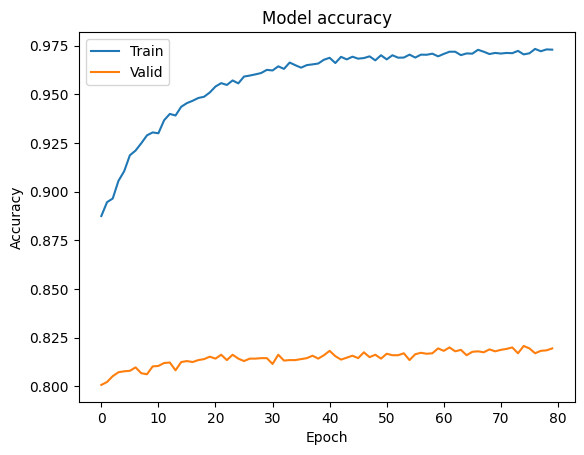

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

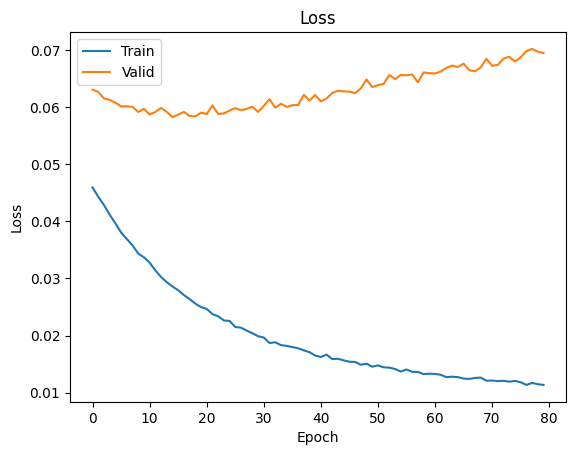

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [27]:
# ewaluacja modelu (po 80 epokach)
eval = model.evaluate(x_val, y_val)

125/125 [==============================] - 1s 9ms/step - loss: 0.0695 - accuracy: 0.8195
